In [1]:
import os
import sys
cwd = os.getcwd()
new_wd = '../src/visualization/'

os.chdir(new_wd)
from multistats import getstats
os.chdir(cwd)

In [21]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import math

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
df = pd.read_csv('../data/interim/prepared_consolidated_data.csv', sep='~', encoding='utf-8')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182776 entries, 0 to 182775
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   file_name                 182776 non-null  object 
 1   sheet_name                182776 non-null  object 
 2   trans_date                182776 non-null  object 
 3   original_gross_amt        182776 non-null  float64
 4   merchant_name             182776 non-null  object 
 5   card_number               182776 non-null  object 
 6   trans_cac_desc_1_imputed  182776 non-null  object 
 7   trans_cac_desc_2_imputed  182776 non-null  object 
 8   directorate_completed     182776 non-null  object 
dtypes: float64(1), object(8)
memory usage: 12.6+ MB


,file_name,sheet_name,trans_date,original_gross_amt,merchant_name,card_number,trans_cac_desc_1_imputed,trans_cac_desc_2_imputed,directorate_completed
0,cusersfinainmndesktoppublish-copy-january-2017...,Sheet1,2017-01-03,72.61,shell kings 587,************5770,Vehicle Fuel,African-Caribbean DC,Adult & Communities
1,cusersfinainmndesktoppublish-copy-january-2017...,Sheet1,2017-01-24,85.51,shell fiveways 387,************1147,Vehicle Fuel,Elders Group - Ladywood,Adult & Communities
2,cusersfinainmndesktoppublish-copy-january-2017...,Sheet1,2017-02-01,10.09,shell fiveways 387,************1147,Vehicle Fuel,Elders Group - Ladywood,Adult & Communities
3,cusersfinainmndesktoppublish-copy-january-2017...,Sheet1,2017-01-04,20.00,mibsons service st,************5804,Vehicle Fuel,Enablement Tyburn Rd,Adult & Communities
4,cusersfinainmndesktoppublish-copy-january-2017...,Sheet1,2017-01-05,50.00,malthurst petroleu,************5804,Vehicle Fuel,Enablement Tyburn Rd,Adult & Communities


________________
### Pandas Profiling

In [4]:
profile = ProfileReport(df, title="Purchase Card Transactions", explorative=True)
profile.to_file('../reports/Data Profile - Purchase Card Transactions.html')

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
profile

________________
### Historical data frame

In [6]:
df_hist = df.groupby(['trans_date'], as_index=False)['original_gross_amt'].agg(['count', 'sum']).rename(columns={'count':'n_transactions','sum':'gross_amt'})
df_hist.describe().T.style.format('{:,.0f}')

,count,mean,std,min,25%,50%,75%,max
n_transactions,"1,332",137,92,1,40,148,214,467
gross_amt,"1,332","23,756","38,402","-630,766","2,209","16,579","30,399","562,059"


In [7]:
df_hist.reset_index(inplace=True)
df_hist.info()
df_hist.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1332 entries, 0 to 1331
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   trans_date      1332 non-null   object 
 1   n_transactions  1332 non-null   int64  
 2   gross_amt       1332 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 31.3+ KB


,trans_date,n_transactions,gross_amt
0,2013-11-12,1,-594.00
1,2014-03-06,1,98.33
2,2014-03-27,1,-10.54
3,2014-04-01,1,94.93
4,2014-04-02,11,2150.25


In [8]:
df_hist['trans_date_year'] = pd.to_datetime(df_hist['trans_date']).dt.year
df_hist['trans_date_month'] = pd.to_datetime(df_hist['trans_date']).dt.month
df_hist['trans_date_day'] = pd.to_datetime(df_hist['trans_date']).dt.day
df_hist.head()

,trans_date,n_transactions,gross_amt,trans_date_year,trans_date_month,trans_date_day
0,2013-11-12,1,-594.00,2013,11,12
1,2014-03-06,1,98.33,2014,3,6
2,2014-03-27,1,-10.54,2014,3,27
3,2014-04-01,1,94.93,2014,4,1
4,2014-04-02,11,2150.25,2014,4,2


trans_date_year,2013,2014,2015,2016,2017,2018
count,12,12,12,12,12,12
mean,0,"2,833","3,681","4,312","3,949",457
std,0,"2,558","1,353",835,"1,523","1,367"
min,0,0,208,"2,553",10,0
25%,0,99,"3,532","3,905","3,599",0
50%,0,"3,082","4,037","4,501","4,374",0
75%,0,"4,120","4,520","4,969","4,925",0
max,1,"8,343","5,014","5,235","5,318","4,747"


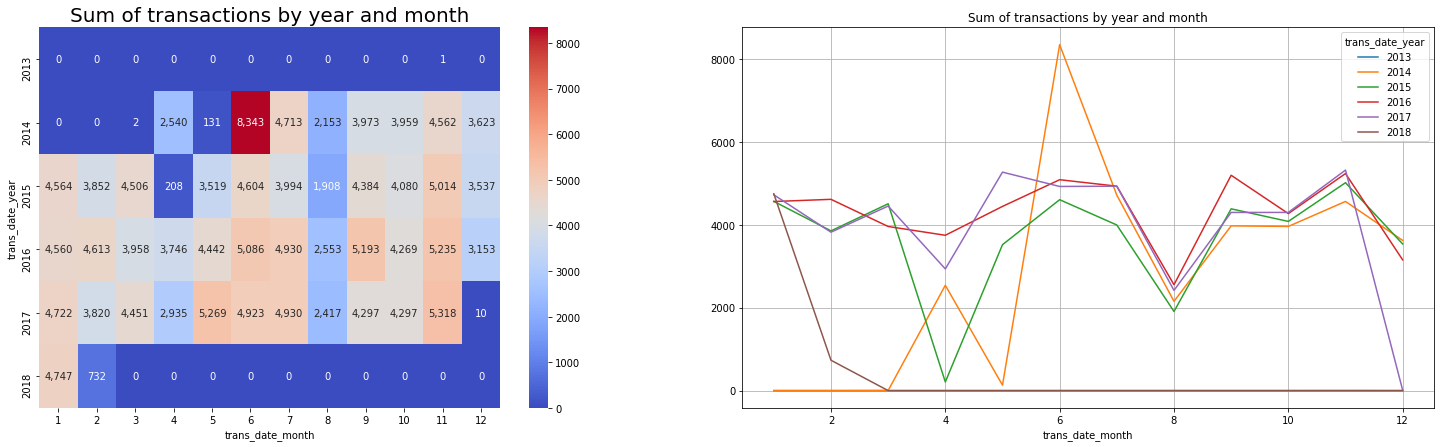

In [9]:
df_heatmap = df_hist.pivot_table(values='n_transactions', index='trans_date_year', columns='trans_date_month', aggfunc='sum', fill_value=0, dropna=False)

f, (heatmap, lineplot) = plt.subplots(1,2,figsize=(25,7), gridspec_kw={'width_ratios':(0.5,0.6)})
sns.heatmap(
    data = df_heatmap,
    annot=True,
    fmt=',.0f',
    cmap = 'coolwarm',
    ax = heatmap
)
heatmap.set_title('Sum of transactions by year and month', fontdict= {'fontsize':20})

df_heatmap.T.plot(kind='line', grid=True, title='Sum of transactions by year and month', ax=lineplot)

df_heatmap.T.describe().style.format('{:,.0f}')

**Analysis**:
1. In there are only one transation on 2013 (november).
2. In 2014 the transactions starts on April, there are 2 transactions on March of the same year, and a low number of transactions on May compared with the rest of the months.
3. On 2015 there are low number of transactions on April.
4. 2016 looks like are the most normal data, the average number of transactions by month is 4,312 with a standard deviation of 835 (lower than other years).
5. 2017 have good data until December.
6. 2018 have only data on January and a little on february.
7. It looks like on November of each year increment the number of transactions.
8. On August of each year we can see lower number of transactions compared with the other months.
9. The most normal data in number of transactions are between May 2015 and November 2017

### Building df_merchant

In [193]:
df_merchant = df.groupby(['merchant_name', 'trans_date'], as_index=False)['original_gross_amt'].agg(['count', 'sum']).rename(columns={'count':'n_transactions','sum':'gross_amt'}).reset_index()
df_merchant['trans_date'] = pd.to_datetime(df_merchant['trans_date'])
df_merchant['trans_date_year'] = pd.to_datetime(df_merchant['trans_date']).dt.year
df_merchant['trans_date_month'] = pd.to_datetime(df_merchant['trans_date']).dt.month
df_merchant['trans_date_day'] = pd.to_datetime(df_merchant['trans_date']).dt.day

df_merchant = df_merchant.query('trans_date_year >= 2015 and trans_date_year <= 2017').pivot_table(
    values=['n_transactions', 'gross_amt'],
    index='merchant_name',
    columns='trans_date_year',
    aggfunc='sum',
    fill_value=0,
    dropna=False,
)
df_merchant.columns = [f'gross_amt_{x}' for x in range(2014,2018)] + [f'n_transactions_{x}' for x in range(2014,2018)]

df_merchant.head()

,gross_amt_2014,gross_amt_2015,gross_amt_2016,gross_amt_2017,n_transactions_2014,n_transactions_2015,n_transactions_2016,n_transactions_2017
merchant_name,,,,,,,,
.carelpress.co.uk,419.70,174.42,0.00,0.00,3,3,0,0
.ukgardensupplies.,0.00,832.93,158.95,115.96,0,2,1,1
01direct ltd,0.00,479.99,0.00,0.00,0,1,0,0
02 (uk) limited,0.00,0.00,0.00,303.22,0,0,0,1
02035190705 book,88.64,0.00,0.00,0.00,1,0,0,0


In [11]:
from pycaret.clustering import *

In [64]:
def percentile_outliers(X, q1, q2):
    f, (b1, b2) = plt.subplots(1,2,figsize=(15,5))
    
    down_q = np.quantile(a=X, q=q1)
    top_q = np.quantile(a=X, q=q2)
    y = [x for x in X if x>down_q and x<top_q]
    outlier = [True if x<=down_q or x>=top_q else False for x in X]
    sns.boxplot(y=X, ax=b1)
    sns.boxplot(y=y, ax=b2)

    print(f'''
    Quantil inferior: {down_q}
    Quantil superior: {top_q}
    Nro observaciones completa: {df_merchant.shape[0]}
    Nro observaciones sin outliers: {len(y)}
    Nro outliers: {df_merchant.shape[0]-len(y)}
    ''')
    
    return outlier

In [65]:
df_merchant.columns

Index(['gross_amt_2014', 'gross_amt_2015', 'gross_amt_2016', 'gross_amt_2017',
       'n_transactions_2014', 'n_transactions_2015', 'n_transactions_2016',
       'n_transactions_2017'],
      dtype='object')


    Quantil inferior: 0.0
    Quantil superior: 2783.307200000008
    Nro observaciones completa: 14923
    Nro observaciones sin outliers: 4249
    Nro outliers: 10674
    


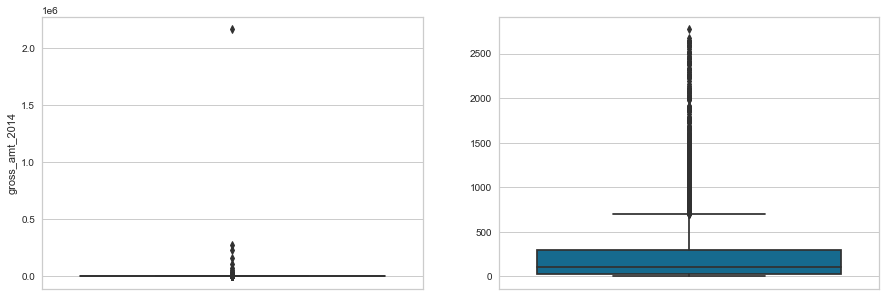

In [94]:
o1 = percentile_outliers(df_merchant['gross_amt_2014'], 0.01, 0.99)


    Quantil inferior: 0.0
    Quantil superior: 3871.4800000000105
    Nro observaciones completa: 14923
    Nro observaciones sin outliers: 5623
    Nro outliers: 9300
    


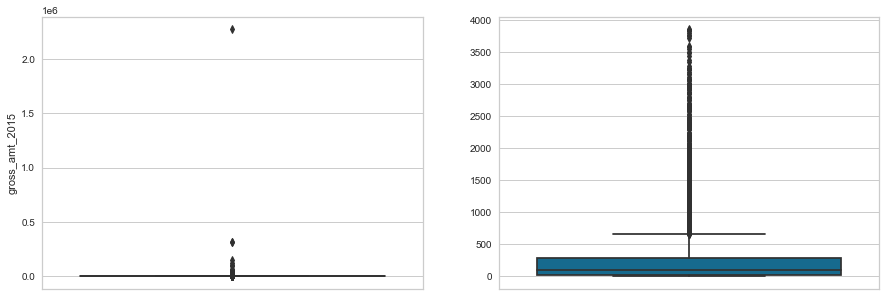

In [99]:
o2 = percentile_outliers(df_merchant['gross_amt_2015'], 0.01, 0.99)


    Quantil inferior: 0.0
    Quantil superior: 3845.0540000000124
    Nro observaciones completa: 14923
    Nro observaciones sin outliers: 5856
    Nro outliers: 9067
    


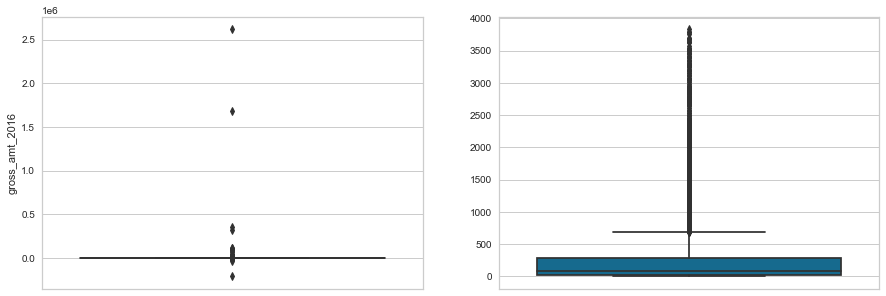

In [104]:
o3 = percentile_outliers(df_merchant['gross_amt_2016'], 0.01, 0.99)


    Quantil inferior: 0.0
    Quantil superior: 3414.6036000000013
    Nro observaciones completa: 14923
    Nro observaciones sin outliers: 5487
    Nro outliers: 9436
    


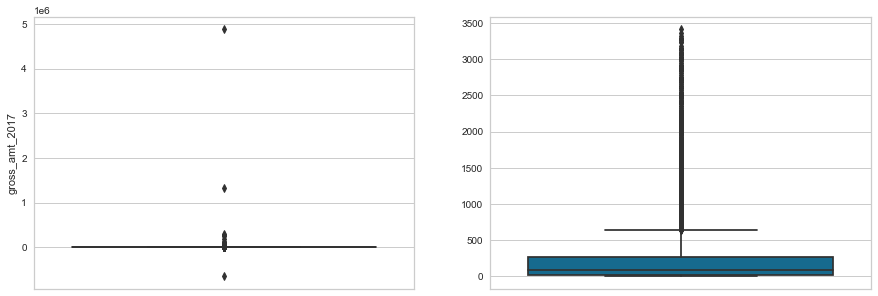

In [112]:
o4 = percentile_outliers(df_merchant['gross_amt_2017'], 0.01, 0.99)


    Quantil inferior: 0
    Quantil superior: 24.0
    Nro observaciones completa: 14923
    Nro observaciones sin outliers: 4287
    Nro outliers: 10636
    


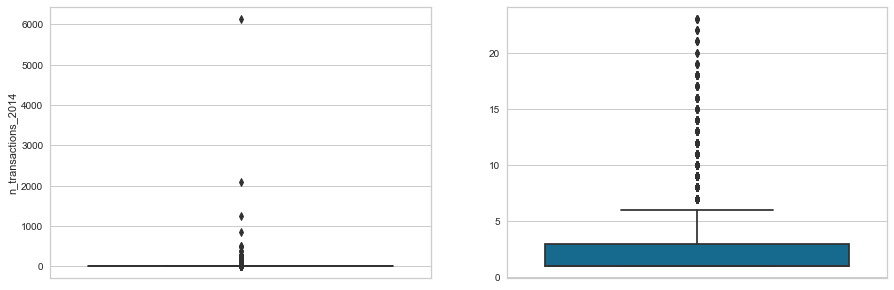

In [113]:
o5 = percentile_outliers(df_merchant['n_transactions_2014'], 0, 0.99)


    Quantil inferior: 0
    Quantil superior: 474.04463999994914
    Nro observaciones completa: 14923
    Nro observaciones sin outliers: 5808
    Nro outliers: 9115
    


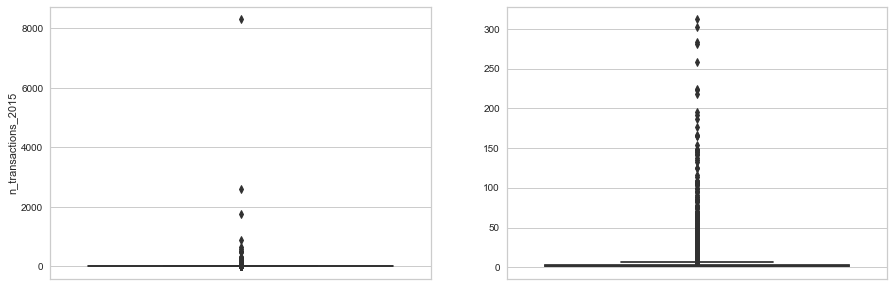

In [128]:
o6 = percentile_outliers(df_merchant['n_transactions_2015'], 0, 0.99946)


    Quantil inferior: 0
    Quantil superior: 879.3696000000054
    Nro observaciones completa: 14923
    Nro observaciones sin outliers: 6077
    Nro outliers: 8846
    


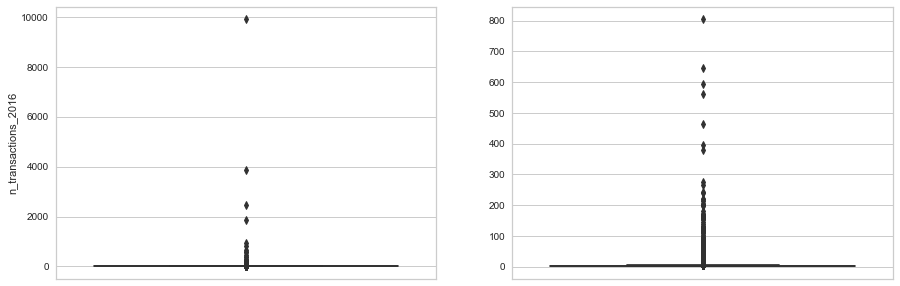

In [136]:
o7 = percentile_outliers(df_merchant['n_transactions_2016'], 0, 0.9997)


    Quantil inferior: 0
    Quantil superior: 1075.572000000233
    Nro observaciones completa: 14923
    Nro observaciones sin outliers: 5767
    Nro outliers: 9156
    


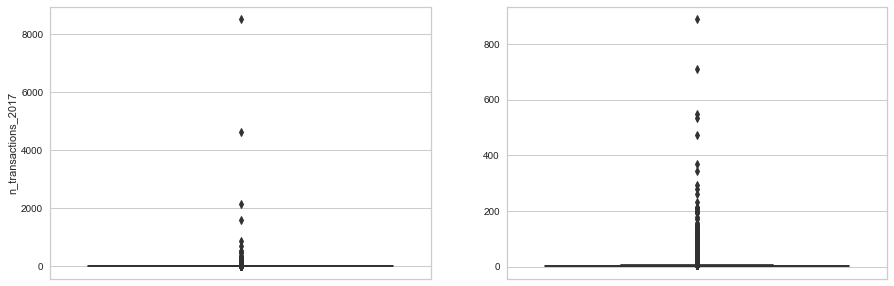

In [142]:
o8 = percentile_outliers(df_merchant['n_transactions_2017'], 0, 0.99975)

In [157]:
df_o = pd.DataFrame({'o1':o1,'o2':o2,'o3':o3,'o4':o4,'o5':o5,'o6':o6,'o7':o7,'o8':o8})
df_o['outlier'] = df_o.apply(lambda x: True if x.sum()>0 else False, axis=1)
df_merchant['outlier'] = df_o['outlier'].values.tolist()
df_o['outlier'].value_counts(dropna=False)

True     14190
False      733
Name: outlier, dtype: int64

In [173]:
df_merchant_wout_outliers = df_merchant[df_merchant['outlier']==False]
setup_clustering_1 = setup(df_merchant_wout_outliers, normalize = True, session_id = 2021)

,Description,Value
0,session_id,2021
1,Original Data,"(733, 9)"
2,Missing Values,False
3,Numeric Features,8
4,Categorical Features,1
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(733, 9)"
9,CPU Jobs,-1


In [174]:
kmeans_1 = create_model('kmeans', num_clusters=5)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3809,241.3732,1.4406,0,0,0


In [175]:
print(kmeans_1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=2021, tol=0.0001, verbose=0)


In [176]:
plot_model(kmeans_1, plot='cluster')

In [177]:
plot_model(kmeans_1, plot='tsne')

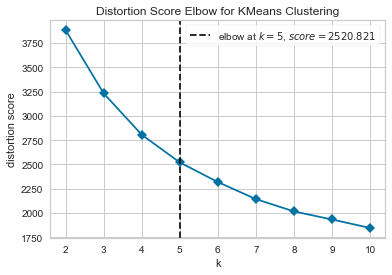

In [178]:
plot_model(kmeans_1, plot='elbow')

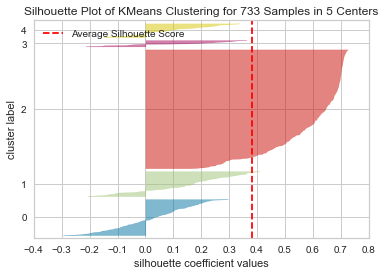

In [179]:
plot_model(kmeans_1, plot='silhouette')

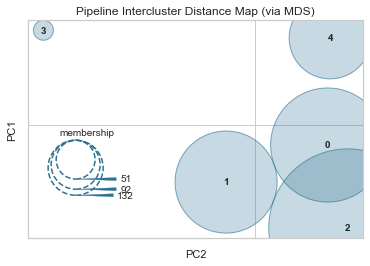

In [180]:
plot_model(kmeans_1, plot='distance')

In [181]:
plot_model(kmeans_1, plot='distribution')

In [184]:
df_merchant_wout_outliers['cluster'] = kmeans_1.labels_
df_merchant_wout_outliers

,gross_amt_2014,gross_amt_2015,gross_amt_2016,gross_amt_2017,n_transactions_2014,n_transactions_2015,n_transactions_2016,n_transactions_2017,outlier,cluster
merchant_name,,,,,,,,,,
11 internet limited,63.47,184.07,406.17,268.55,3,2,15,12,False,2
123-reg.co.uk,341.75,99.32,843.04,664.49,2,5,7,6,False,2
43036690 costa coffee,23.40,21.65,36.85,2.70,6,6,7,1,False,2
a f blakemore cashcarry,1096.68,398.70,417.95,1620.10,16,6,8,13,False,1
a19 services north,42.40,37.71,73.11,18.26,12,11,14,3,False,1
...,...,...,...,...,...,...,...,...,...,...
www.voucherexpress.co.,42.95,308.70,950.50,677.25,1,2,6,5,False,2
www.widgit.com,304.74,251.98,142.79,881.97,1,2,2,4,False,2
www.wvhowe.co.uk,32.03,387.46,745.15,521.21,1,2,6,2,False,2


In [187]:
def tblfmt(tbl):
    for col in tbl.columns:
        tbl[col] = tbl[col].apply(lambda x: f'{x:,.0f}')
    return tbl

def plot_var(df, var):
    df.sort_values(by='cluster', ascending=False, inplace=True)

    lcl = []
    for cl in df['cluster'].unique():
        t = tblfmt(df[df['cluster']==cl].describe())
        t['cluster'] = cl
        t = t.rename(columns={var:cl})
        lcl += [t[cl]]
    print('-'*20 + f' {var} ' + '-'*20)
    print(tabulate(pd.concat(lcl, axis=1), headers='keys', tablefmt='simple'))

In [190]:
plot_var(df_merchant_wout_outliers, var='gross_amt_2014')

-------------------- gross_amt_2014 --------------------
       4      3      2      1      0
-----  -----  -----  -----  -----  -----
count  51     24     434    92     132
mean   1,612  405    172    567    476
std    644    306    225    461    408
min    124    9      1      19     5
25%    1,119  160    38     181    179
50%    1,600  349    94     439    361
75%    2,126  576    202    828    654
max    2,672  1,163  1,466  1,772  2,016


In [191]:
plot_var(df_merchant_wout_outliers, var='gross_amt_2015')

-------------------- gross_amt_2015 --------------------
       4      3      2      1      0
-----  -----  -----  -----  -----  -----
count  51     24     434    92     132
mean   1,751  1,398  204    526    997
std    814    937    223    460    637
min    42     94     0      19     27
25%    1,124  585    47     196    547
50%    1,606  1,267  115    393    899
75%    2,255  1,907  292    725    1,335
max    3,859  3,843  1,223  2,165  3,255


In [192]:
plot_var(df_merchant_wout_outliers, var='gross_amt_2016')

-------------------- gross_amt_2016 --------------------
       4      3      2      1      0
-----  -----  -----  -----  -----  -----
count  51     24     434    92     132
mean   2,229  1,666  208    457    1,184
std    1,360  1,114  255    329    892
min    264    216    -85    12     12
25%    1,289  695    45     216    584
50%    1,915  1,639  115    380    915
75%    2,913  2,077  275    645    1,562
max    6,536  4,664  2,196  1,377  5,325


### original_gross_amt

In [ ]:
import math

In [ ]:
math.log10()

### Building a dataset with a merchant in each row to perform a clustering analysis